In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
from torchvision.transforms.functional import to_tensor, to_pil_image
import matplotlib.pyplot as plt

import torch.nn.functional as F
from pprint import pprint
from PIL import Image
from torch.autograd import grad
import torchvision


/home/bingguang/opt/anaconda3/envs/iv/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/bingguang/opt/anaconda3/envs/iv/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Conv2d(3, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
        )
        self.fc = nn.Sequential(
            nn.Linear(768, 100)
        )
        
    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        # print(out.size())
        out = self.fc(out)
        return out
    
def label_to_onehot(target, num_classes=100):
    target = torch.unsqueeze(target, 1)
    onehot_target = torch.zeros(target.size(0), num_classes, device=target.device)
    onehot_target.scatter_(1, target, 1)
    return onehot_target

def weights_init(m):
    if hasattr(m, "weight"):
        m.weight.data.uniform_(-0.5, 0.5)
    if hasattr(m, "bias"):
        m.bias.data.uniform_(-0.5, 0.5)
        
def cross_entropy_for_onehot(pred, target):
    return torch.mean(torch.sum(- target * F.log_softmax(pred, dim=-1), 1))



In [ ]:
img_index = 25

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dst = datasets.CIFAR100("~/.torch", download=True)
#dst = datasets.MNIST("~/.torch", train=True, download=True, transform=transforms.ToTensor())
tt = transforms.ToPILImage()
gt_data = tp(dst[img_index][0]).to(device)
gt_data = gt_data.view(1, *gt_data.size())
gt_label = torch.Tensor([dst[img_index][1]]).long().to(device)
gt_label = gt_label.view(1, )
gt_onehot_label = label_to_onehot(gt_label)
plt.imshow(tt(gt_data[0].cpu()))

Using downloaded and verified file: /home/bingguang/.torch/MNIST/raw/train-images-idx3-ubyte.gz
Extracting /home/bingguang/.torch/MNIST/raw/train-images-idx3-ubyte.gz to /home/bingguang/.torch/MNIST/raw

Using downloaded and verified file: /home/bingguang/.torch/MNIST/raw/train-labels-idx1-ubyte.gz
Extracting /home/bingguang/.torch/MNIST/raw/train-labels-idx1-ubyte.gz to /home/bingguang/.torch/MNIST/raw

Using downloaded and verified file: /home/bingguang/.torch/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting /home/bingguang/.torch/MNIST/raw/t10k-images-idx3-ubyte.gz to /home/bingguang/.torch/MNIST/raw




KeyboardInterrupt: 

In [4]:
net = LeNet().to(device)
net.apply(weights_init)
criterion = cross_entropy_for_onehot
pred = net(gt_data)
y = criterion(pred, gt_onehot_label)
dy_dx = torch.autograd.grad(y, net.parameters())
original_dy_dx = list((_.detach().clone() for _ in dy_dx))

In [5]:
dummy_data = torch.randn(gt_data.size()).to(device).requires_grad_(True)
dummy_label = torch.randn(gt_onehot_label.size()).to(device).requires_grad_(True)

optimizer = torch.optim.LBFGS([dummy_data, dummy_label])

history = []
prev_loss = None
prev_dummy_data = None
threshold = 10.0

for iters in range(300):
    def closure():
        optimizer.zero_grad()

        dummy_pred = net(dummy_data) 
        dummy_onehot_label = F.softmax(dummy_label, dim=-1)
        dummy_loss = criterion(dummy_pred, dummy_onehot_label)
        dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)
        
        grad_diff = 0
        for gx, gy in zip(dummy_dy_dx, original_dy_dx): 
            grad_diff += ((gx - gy) ** 2).sum()
        grad_diff.backward()
        
        return grad_diff
    
    optimizer.step(closure)
    
    current_loss = closure()
    # 检查损失值是否大幅增加
    if prev_loss is not None and current_loss.item() - prev_loss > threshold:
        print(f"Loss increased significantly at iteration {iters}:")
        print(f"Previous loss: {prev_loss:.4f}, Current loss: {current_loss.item():.4f}")

        # 打印 dummy_data[0] 的大小
        print(f"Size of dummy_data[0]: {dummy_data[0].shape}")

        # 打印上一轮和当前轮的 dummy_data[0]
        if prev_dummy_data is not None:
            print(f"Dummy data at iteration {iters - 1}:")
            print(prev_dummy_data.cpu())

        print(f"Dummy data at iteration {iters}:")
        print(dummy_data[0].cpu())

        # 可视化上一轮和当前轮的 dummy_data[0]
        if prev_dummy_data is not None:
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(tt(prev_dummy_data.cpu()))
            plt.title(f"Dummy data at iteration {iters - 1}")
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.imshow(tt(dummy_data[0].cpu()))
            plt.title(f"Dummy data at iteration {iters}")
            plt.axis('off')
            plt.show()
        else:
            plt.imshow(tt(dummy_data[0].cpu()))
            plt.title(f"Dummy data at iteration {iters}")
            plt.axis('off')
            plt.show()
        
    prev_loss = current_loss.item()  # 更新上一轮的损失值
    prev_dummy_data = dummy_data[0].clone()  # 更新上一轮的 dummy_data[0]
    
    if prev_loss is not None and current_loss.item() - prev_loss > threshold:
        break
    
    if iters % 10 == 0: 
        print(iters, "%.4f" % current_loss.item())
        history.append(tt(dummy_data[0].cpu()))
        
'''dummy_data = torch.randn(gt_data.size()).to(device).requires_grad_(True)
#dummy_label = torch.randn(gt_onehot_label.size()).to(device).requires_grad_(True)
dummy_label = gt_onehot_label

optimizer = torch.optim.SGD([dummy_data], lr=0.01)

history = []
for iters in range(3000000):
    optimizer.zero_grad()
    dummy_pred = net(dummy_data)
    dummy_loss = criterion(dummy_pred, dummy_label)
    dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)
    
    grad_diff = 0
    for gx, gy in zip(dummy_dy_dx, original_dy_dx): 
        grad_diff += ((gx - gy) ** 2).sum()
        
    grad_diff.backward()
    optimizer.step()
    
    if iters % 10 == 0:
        current_loss = grad_diff
        print(iters, "%.4f" % current_loss.item())
    
    if iters % 100000 == 0: 
        history.append(tt(dummy_data[0].cpu()))'''

0 33.9443
10 1.0213
20 0.2120
30 0.0664
40 0.0279
50 0.0147
60 0.0094
70 0.0068
80 0.0051
90 0.0042
100 0.0035
110 0.0029
120 0.0024
130 0.0021
140 0.0091
150 0.0016
160 0.0014
170 0.0014
180 0.0011
190 0.0011
200 0.0010


KeyboardInterrupt: 

Dummy label is 84.


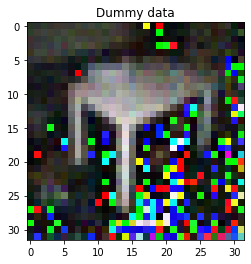

In [6]:
plt.imshow(tt(dummy_data[0].cpu()))
plt.title("Dummy data")
print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())

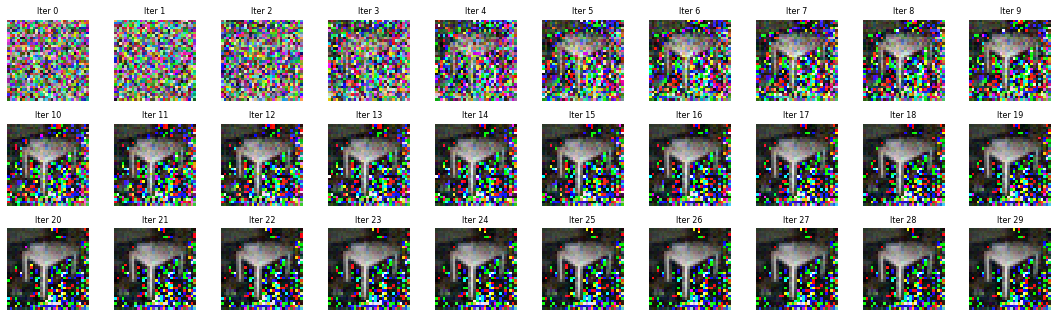

In [7]:
import matplotlib.pyplot as plt

# 假设 history 是一个包含图像的列表
num_images = len(history)
cols = 10  # 每行显示的图像数量
rows = (num_images + cols - 1) // cols  # 计算需要的行数

plt.figure(figsize=(15, rows * 1.5))
for i, img in enumerate(history):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)  # 显示图像
    plt.axis('off')  # 关闭坐标轴显示
    plt.title(f"Iter {i}", fontsize=8)  # 显示标题（迭代次数）
plt.tight_layout()
plt.show()


In [58]:
len(history)

30